In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [15]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [16]:
# Inspect column names and data types for measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Inspect column names and data types for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [19]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [27]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
recent_date

'2017-08-23'

In [ ]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

In [28]:
# Starting from the most recent data point in the database.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first().date
recent_date

'2017-08-23'

In [36]:
# Calculate the date one year from the last date in data set.
last_year = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
last_year

datetime.datetime(2016, 8, 23, 0, 0)

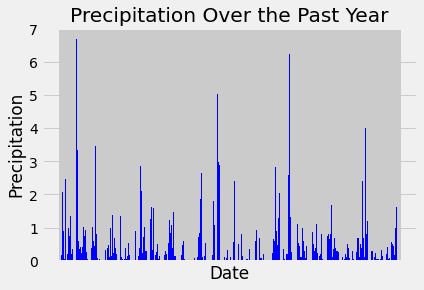

In [55]:
# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_prcp_df = pd.DataFrame(
    data=last_year_prcp,
    columns=['Date','Precipitation']
)


# Sort the dataframe by date
last_year_prcp_df.sort_values(by=['Date'])


# Drop N/A's
last_year_prcp_df = last_year_prcp_df.dropna()


# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(
    x=last_year_prcp_df['Date'], 
    height=last_year_prcp_df['Precipitation'], color='blue')
plt.xlabel("Date")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False  # labels along the bottom edge are off
)
plt.ylabel("Precipitation")
plt.title("Precipitation Over the Past Year")
plt.show()

In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data


# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()